This notebook extracts key phrases from the text data using Microsoft cognitive services. Then, it looks up the image urls using the Clarifai API. This is used to extract tags. Now, the key phrases extracted are compared with the image tags. This is then used to derive a metric for comparison between the two sets of tags, which is done using the NLTK library. The parameters are fed into an SVM classifier for classification

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

f = pd.read_csv('fake.csv')
f.head(2)
# f[f.spam_score>0].count()
# a = f.spam_score.unique()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,25689.0,Re: Why Did Attorney General Loretta Lynch Ple...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias


In [2]:
g = pd.read_csv('facebook-fact-check.csv')
g.head(2)
a = g.Rating.unique()
print a
for i in a:
    print g[g.Rating == i].count()

['no factual content' 'mostly true' 'mixture of true and false'
 'mostly false']
account_id        264
post_id           264
Category          264
Page              264
Post URL          264
Date Published    264
Post Type         264
Rating            264
Debate             40
share_count       235
reaction_count    264
comment_count     264
dtype: int64
account_id        1669
post_id           1669
Category          1669
Page              1669
Post URL          1669
Date Published    1669
Post Type         1669
Rating            1669
Debate             236
share_count       1633
reaction_count    1667
comment_count     1667
dtype: int64
account_id        245
post_id           245
Category          245
Page              245
Post URL          245
Date Published    245
Post Type         245
Rating            245
Debate             15
share_count       241
reaction_count    245
comment_count     245
dtype: int64
account_id        104
post_id           104
Category          104
Page      

In [3]:
f['class_type'] = 0
f['total_count'] = 0
for i in range(len(f)):
    if f.ix[i, 'spam_score'] < 0.2:
        f.ix[i,'class_type'] = "Real"
        
    elif f.ix[i,'spam_score'] > 0.2 and f.ix[i,'spam_score'] < 0.8:
        f.ix[i,'class_type'] = "Ambiguous"
        
    else:
        f.ix[i,'class_type'] = "Fake"
        
    f.ix[i,'total_count'] = f.ix[i, 'likes'] + f.ix[i, 'comments'] + f.ix[i, 'shares'] + f.ix[i, 'participants_count']
    
# f = f.drop('class', 1)
f.head()


,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,...,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,class_type,total_count
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,Real,1
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,0,reasoning with facts,2016-10-29T08:47:11.259+03:00,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,2016-10-29T08:47:11.259+03:00,100percentfedup.com,US,...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,Real,1
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,0,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,2016-10-31T01:41:49.479+02:00,100percentfedup.com,US,...,0.000,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,Real,1
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,0,Fed Up,2016-11-01T05:22:00.000+02:00,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,2016-11-01T15:46:26.304+02:00,100percentfedup.com,US,...,0.068,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,Real,0
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,0,Fed Up,2016-11-01T21:56:00.000+02:00,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,2016-11-01T23:59:42.266+02:00,100percentfedup.com,US,...,0.865,http://100percentfedup.com/wp-content/uploads/...,0,0,0,0,0,bias,Fake,0


In [4]:
f.head()
y = pd.DataFrame()
y['output'] = f['class_type']
f = f.drop('class_type', 1)
f.head()
y['output_label'] = 0
for i in range(len(y)):
    if y.ix[i,'output'] == "Fake":
        y.ix[i,'output_label'] = 1
    elif y.ix[i,'output'] == "Ambiguous":
        y.ix[i,'output_label'] = 2
    else:
        y.ix[i,'output_label'] = 0
        
y.head()

,output,output_label
0,Real,0
1,Real,0
2,Real,0
3,Real,0
4,Fake,1


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(f, y, test_size=0.2, random_state=42, stratify = y
                                                   )
print len(X_train)
print len(X_test)
print len(y_train)
print len(y_test)

10399
2600
10399
2600


In [6]:
X_train.head()

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,...,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,total_count
11400,aaf710db25ffa0c21ff92b7cff052098fa5307ed,0,Brett T.,2016-10-27T02:15:17.517+03:00,Who rode it best? Jesse Jackson mounts up to f...,Who rode it best? Jesse Jackson mounts up to f...,english,2016-10-27T02:15:17.517+03:00,twitchy.com,US,...,Who rode it best? Jesse Jackson mounts up to f...,0.0,http://twitchy.com/wp-content/uploads/2016/10/...,0,1,0,0,0,bs,1
9562,42ed84d36e018dd7012ec7c0d5be3772f15ac0c8,0,Editor,2016-10-28T03:32:10.905+03:00,Scientists find 19 pieces of NON-HUMAN DNA in ...,"According to a new study, eight percent of our...",english,2016-10-28T03:32:10.905+03:00,theeventchronicle.com,US,...,Scientists find 19 pieces of NON-HUMAN DNA in ...,0.0,NaN,0,1,0,0,0,bs,1
5243,42abbec003b0d993a6554362925b43b1cab05ccb,0,IWB,2016-10-27T17:13:41.770+03:00,What Happens If Trump LOSES The Election? What...,What Happens If Trump LOSES The Election? What...,english,2016-10-27T17:13:41.770+03:00,investmentwatchblog.com,US,...,What Happens If Trump LOSES The Election? What...,0.0,NaN,0,1,0,0,0,bs,1
3777,ef1be063e8754ac155f3950f554510d757063d6a,0,Lloyd Billingsley,2016-11-04T11:05:00.000+02:00,POTUS FLOTUS Pocus,The president and Hillary Clinton share a “stu...,english,2016-11-04T12:29:09.876+02:00,frontpagemag.com,US,...,POTUS FLOTUS Pocus,0.0,http://www.frontpagemag.com/sites/default/file...,0,1,0,0,0,hate,1
3372,88df1b9d21daa1192270d34842bea3174ca09c7d,0,Dr. Stoyan Sarg,2016-11-01T05:47:47.225+02:00,Are We on the Eve of Total Life Extinction?,"A 23 kiloton tower shot called BADGER, fired o...",english,2016-11-01T05:47:47.225+02:00,foreignpolicyjournal.com,US,...,Are We on the Eve of Total Life Extinction?,0.0,NaN,0,1,0,0,0,bs,1


In [7]:
X_train[['text']].head()

,text
11400,Who rode it best? Jesse Jackson mounts up to f...
9562,"According to a new study, eight percent of our..."
5243,What Happens If Trump LOSES The Election? What...
3777,The president and Hillary Clinton share a “stu...
3372,"A 23 kiloton tower shot called BADGER, fired o..."


In [8]:
import httplib, urllib, base64

headers = {
    # Request headers
    'Content-Type': 'application/json',
    'Ocp-Apim-Subscription-Key': 'b1b17649c5cb443a81c82343165d0a27',
}

# body = {
#   "documents": [
#     {"id": "1","text": "['\Today is a good day. It was a fine, bright evening. It made me very happy"
#     },
#     {
#       "id": "2",
#       "text": "Today is a bad day. It was not fine, dull evening. It made me very unhappy"
#     }]
# }

body = {
  "documents": [
    {"id":"1513","text": "[ \'This is the biggest story not being reported.\\nWhile the world teeters on the brink of World War 3, the media is reporting on Kim Kardashian.\\nMeanwhile the Russians are deploying the new Satan-2 missile (designation given by NATO).\\nEach Satan-2 missile has the power to devastate an area the size of Texas.\\nhttp://www.nbcnews.com/news/wo... \\nhttp://www.dailymail.co.uk/sci...\']"}]
}

print body

params = urllib.urlencode({
})

try:
    conn = httplib.HTTPSConnection('westus.api.cognitive.microsoft.com')
    conn.request("POST", "/text/analytics/v2.0/keyPhrases?%s" % params, str(body), headers)
    response = conn.getresponse()
    data = response.read()
    print data
    conn.close()
except Exception as e:
    print("[Errno {0}] {1}".format(e.errno, e.strerror))

{'documents': [{'text': "[ 'This is the biggest story not being reported.\\nWhile the world teeters on the brink of World War 3, the media is reporting on Kim Kardashian.\\nMeanwhile the Russians are deploying the new Satan-2 missile (designation given by NATO).\\nEach Satan-2 missile has the power to devastate an area the size of Texas.\\nhttp://www.nbcnews.com/news/wo... \\nhttp://www.dailymail.co.uk/sci...']", 'id': '1513'}]}
{"documents":[{"keyPhrases":["missile","world teeters","new Satan","brink of World War","nEach Satan","Russians","power","Kim Kardashian","nMeanwhile","area","media","NATO","designation","size of Texas","biggest story"],"id":"1513"}],"errors":[]}


In [9]:
text_train = pd.DataFrame()
text_train = X_train[['text']]

In [10]:
text_train.reset_index(drop=True)
# text_train = text_train.drop('index')

,text
0,Who rode it best? Jesse Jackson mounts up to f...
1,"According to a new study, eight percent of our..."
2,What Happens If Trump LOSES The Election? What...
3,The president and Hillary Clinton share a “stu...
4,"A 23 kiloton tower shot called BADGER, fired o..."
5,posted by Eddie Gun man have stolen a Dirty Bo...
6,"VICE News Fri, November 18, 2016 10:38am URL: ..."
7,"Obamacare is working exactly as planned, and t..."
8,Convinced that previous snow plowing policies ...
9,"By Rahul Manchanda, Esq. on November 10, 2016 ..."


In [11]:

text_test = pd.DataFrame()
text_test = X_test[['text']]
text_test = text_test.reset_index(drop=True)

In [12]:
# text_test['temp'] = 0
# count = 1
# for i in range(len(text_test)):
#     text_test.ix[i,'temp'] = count
#     count += 1
text_test.head()

,text
0,This is the biggest story not being reported.\...
1,". This Ginger Tea Recipe Cleanses the Liver, D..."
2,". NATO, US & UK Assemble Largest Troop Buildup..."
3,November 18: Daily Contrarian Reads By David S...
4,We Are Change \nAs disturbing revelations abou...


In [13]:
text_test['id'] = 0
for i in range(len(text_test)):
    text_test.ix[i,'id'] = str(i)
text_test.head()

,text,id
0,This is the biggest story not being reported.\...,0
1,". This Ginger Tea Recipe Cleanses the Liver, D...",1
2,". NATO, US & UK Assemble Largest Troop Buildup...",2
3,November 18: Daily Contrarian Reads By David S...,3
4,We Are Change \nAs disturbing revelations abou...,4


In [14]:
text_train = text_train.reset_index(drop=True)
text_train['id'] = 0
for i in range(len(text_train)):
    text_train.ix[i,'id'] = str(i)
text_train.head()

,text,id
0,Who rode it best? Jesse Jackson mounts up to f...,0
1,"According to a new study, eight percent of our...",1
2,What Happens If Trump LOSES The Election? What...,2
3,The president and Hillary Clinton share a “stu...,3
4,"A 23 kiloton tower shot called BADGER, fired o...",4


In [15]:

blah = (text_test.to_dict(orient='records'))


In [16]:
# j = text_test.groupby(['id','text'])

In [17]:
import httplib, urllib, base64
from bs4 import BeautifulSoup
import lxml
import re
import unicodedata
import sys
import time

b = []
count = 0
detained_list_test = []
all_the_test_data = []
# body = {
#   "documents": [
#     {"id":"1513","text": "[ \'This is the biggest story not being reported.\\nWhile the world teeters on the brink of World War 3, the media is reporting on Kim Kardashian.\\nMeanwhile the Russians are deploying the new Satan-2 missile (designation given by NATO).\\nEach Satan-2 missile has the power to devastate an area the size of Texas.\\nhttp://www.nbcnews.com/news/wo... \\nhttp://www.dailymail.co.uk/sci...\']"}]
# }
for i in range((len(text_test)/200)+1):
    b = []
    for j in range(i*200, (i+1)*200):
        if j >= len(text_test):
            break
        headers = {
            # Request headers
            'Content-Type': 'application/json',
            'Ocp-Apim-Subscription-Key': 'b1b17649c5cb443a81c82343165d0a27',
        }

        a = BeautifulSoup(str(text_test.ix[j,'text'])).get_text()
        letters_only = re.sub("[^a-zA-Z]", " ", a)
        letters_only = unicodedata.normalize('NFKD', letters_only).encode('ascii','ignore')
        if letters_only.isspace():
            detained_list_test.append(j)
            continue
        if sys.getsizeof(letters_only) > 4240:
            letters_only = letters_only[:3239]

        splitted_words = letters_only.split()
        letters_only = " ".join(splitted_words)
        if len(letters_only) < 15:
            detained_list_test.append(j)
            continue
    #     if j in [6,11,13,16,17,18,19,28]:
    #         print sys.getsizeof(letters_only)

        b.append({"id":str(text_test.ix[j,'id']), "text": letters_only})
    body = {"documents": b}


    count += 1
    #     if count == 5:
    #         break

    params = urllib.urlencode({
    })

    try:
        conn = httplib.HTTPSConnection('westus.api.cognitive.microsoft.com')
        conn.request("POST", "/text/analytics/v2.0/keyPhrases?%s" % params, str(body), headers)
        response = conn.getresponse()
        data = response.read()
        print len(data)
        all_the_test_data.append(data)
        conn.close()
        time.sleep(1)
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))
# time.sleep(20)
    

/Users/abhishekvasu/anaconda3/lib/python2.7/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 162 of the file /Users/abhishekvasu/anaconda3/lib/python2.7/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "html5lib")

  markup_type=markup_type))


189040
181669
179246
194105
191927
191897
183621
190987
193234
182725
207059
194356
176916
130


In [18]:
import httplib, urllib, base64
from bs4 import BeautifulSoup
import lxml
import re
import unicodedata
import sys
import time

b = []
count = 0
detained_list_train = []
all_the_train_data = []
# body = {
#   "documents": [
#     {"id":"1513","text": "[ \'This is the biggest story not being reported.\\nWhile the world teeters on the brink of World War 3, the media is reporting on Kim Kardashian.\\nMeanwhile the Russians are deploying the new Satan-2 missile (designation given by NATO).\\nEach Satan-2 missile has the power to devastate an area the size of Texas.\\nhttp://www.nbcnews.com/news/wo... \\nhttp://www.dailymail.co.uk/sci...\']"}]
# }
for i in range((len(text_train)/200)+1):
    b = []
    for j in range(i*200, (i+1)*200):
        if j >= len(text_train):
            break
        headers = {
            # Request headers
            'Content-Type': 'application/json',
            'Ocp-Apim-Subscription-Key': 'b1b17649c5cb443a81c82343165d0a27',
        }

        a = BeautifulSoup(str(text_train.ix[j,'text'])).get_text()
        letters_only = re.sub("[^a-zA-Z]", " ", a)
        letters_only = unicodedata.normalize('NFKD', letters_only).encode('ascii','ignore')
        if letters_only.isspace():
            detained_list_train.append(j)
            continue
        if sys.getsizeof(letters_only) > 4240:
            letters_only = letters_only[:3239]

        splitted_words = letters_only.split()
        letters_only = " ".join(splitted_words)
        if len(letters_only) < 15:
            detained_list_train.append(j)
            continue
    #     if j in [6,11,13,16,17,18,19,28]:
    #         print sys.getsizeof(letters_only)

        b.append({"id":str(text_train.ix[j,'id']), "text": letters_only})
    body = {"documents": b}


    count += 1
    #     if count == 5:
    #         break

    params = urllib.urlencode({
    })

    try:
        conn = httplib.HTTPSConnection('westus.api.cognitive.microsoft.com')
        conn.request("POST", "/text/analytics/v2.0/keyPhrases?%s" % params, str(body), headers)
        response = conn.getresponse()
        data = response.read()
        print len(data)
        all_the_train_data.append(data)
        conn.close()
        time.sleep(1)
    except Exception as e:
        print("[Errno {0}] {1}".format(e.errno, e.strerror))

180382
174790
198841
191609
189153
184962
203975
183522
203093
194743
191018
183336
185780
195919
187901
188205
193703
191215
188234
200040
200613
197589
177433
200675
180199
172576
181863
182918
190046
199077
183377
180349
183235
199343
182770
193090
200093
187865
193566
191830
185198
185237
171493
194447
191675
193329
179406
187821
195893
199926
201577
188741


In [19]:
print len(all_the_test_data)
print len(all_the_train_data)
print len(detained_list_train)
print len(detained_list_test)

14
52
262
71


In [20]:
# {'documents': [{'text': "[ 'This is the biggest story not being reported.\\nWhile the world teeters on the brink of World War 3, the media is reporting on Kim Kardashian.\\nMeanwhile the Russians are deploying the new Satan-2 missile (designation given by NATO).\\nEach Satan-2 missile has the power to devastate an area the size of Texas.\\nhttp://www.nbcnews.com/news/wo... \\nhttp://www.dailymail.co.uk/sci...']", 'id': '1513'}]}

# {'documents': ['{"id":"1513","text": "[ \'This is the biggest story not being reported.\\nWhile the world teeters on the brink of World War 3, the media is reporting on Kim Kardashian.\\nMeanwhile the Russians are deploying the new Satan-2 missile (designation given by NATO).\\nEach Satan-2 missile has the power to devastate an area the size of Texas.\\nhttp://www.nbcnews.com/news/wo... \\nhttp://www.dailymail.co.uk/sci...\']"}']}

# [6,11,13,16,17,18,19,28]
import json
import numpy as np
# print type(all_the_test_data[0])
abcd_test = []
for i in range(len(all_the_test_data)):
    abcd_test.append(json.loads(all_the_test_data[i]))
    
print (abcd_test[0]['documents'][0]['keyPhrases'])
print len(abcd_test[0]['documents'])

[u'world teeters', u'brink of World War', u'size of Texas http www nbcnews com news wo http www dailymail', u'new Satan missile designation', u'media', u'NATO', u'Russians', u'Kim Kardashian', u'power', u'uk sci', u'area', u'biggest story']
197


In [21]:
map_test = {}
for i in range(len(abcd_test)-1):
    for j in range(len(abcd_test[i]['documents'])):
#         print i
        map_test[abcd_test[i]['documents'][j]['id']] = abcd_test[i]['documents'][j]['keyPhrases']
print len(map_test)

2529


In [22]:
abcd_train = []
for i in range(len(all_the_train_data)):
    abcd_train.append(json.loads(all_the_train_data[i]))

In [23]:
map_train = {}
for i in range(len(abcd_train)):
    for j in range(len(abcd_train[i]['documents'])):
        map_train[abcd_train[i]['documents'][j]['id']] = abcd_train[i]['documents'][j]['keyPhrases']

In [24]:
print len(map_train)

10137


In [25]:
X_train = X_train.reset_index(drop=True)
# X_train.head()
X_test = X_test.reset_index(drop=True)
# X_test.head()
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [26]:
len(detained_list_train)
len(X_train) - 253
len(all_the_train_data)

52

In [27]:
from clarifai import rest
from clarifai.rest import ClarifaiApp
from clarifai.rest import Image as ClImage
app = ClarifaiApp("YSiXrmkG3eH5YX-T0_IgOP2EiQCjUSSU3-Zi8-Ud", "7ZMENkzvW96jYqAw1cskml2tCYsnxMXWjcGsxTso")
model = app.models.get('general-v1.3')
count = 0
clarifai_train = {}
blacklist = X_train[pd.isnull(X_train['main_img_url'])]
print len(blacklist)
for i in range(2000):
    count += 1
    if i in detained_list_train:
        continue
    else:
        blah = []
        if i in blacklist:
            clarifai_train[i] = ["NA"]
        else:
            url = X_train.ix[i,'main_img_url']
            try:
                image = ClImage(url)
                clarifai_output = model.predict([image])
            except:
                clarifai_train[i] = ["NA"]
                continue
            for k in range(len(clarifai_output['outputs'][0]['data']['concepts'])):
                blah.append(clarifai_output['outputs'][0]['data']['concepts'][k]['name'])
            clarifai_train[i] = blah
#             except:
#                 clarifai_train[i] = "NA"
    if count%500 ==0:
        print count
# print clarifai_train

Hey! Clarifai Python Client v2.0.28 upgrade available.


2931
1000
1500


In [28]:
len(clarifai_train)

1948

In [29]:
text_train.head()

,text,id
0,Who rode it best? Jesse Jackson mounts up to f...,0
1,"According to a new study, eight percent of our...",1
2,What Happens If Trump LOSES The Election? What...,2
3,The president and Hillary Clinton share a “stu...,3
4,"A 23 kiloton tower shot called BADGER, fired o...",4


In [30]:
from clarifai import rest
from clarifai.rest import ClarifaiApp
from clarifai.rest import Image as ClImage
app = ClarifaiApp("YSiXrmkG3eH5YX-T0_IgOP2EiQCjUSSU3-Zi8-Ud", "7ZMENkzvW96jYqAw1cskml2tCYsnxMXWjcGsxTso")
model = app.models.get('general-v1.3')
count = 0
clarifai_test = {}
blacklist = X_test[pd.isnull(X_test['main_img_url'])]
print len(blacklist)
for i in range(200): #len(X_test)):
    count += 1
    if i in detained_list_test:
        continue
    else:
        blah = []
        if i in blacklist:
            clarifai_test[i] = ["NA"]
        else:
            url = X_test.ix[i,'main_img_url']
            try:
                image = ClImage(url)
                clarifai_output = model.predict([image])
                for k in range(len(clarifai_output['outputs'][0]['data']['concepts'])):
                    blah.append(clarifai_output['outputs'][0]['data']['concepts'][k]['name'])
                clarifai_test[i] = blah
            except:
                clarifai_test[i] = "NA"
    if count%500 ==0:
        print count

Hey! Clarifai Python Client v2.0.28 upgrade available.


709


In [33]:
print clarifai_test[1]

[u'woman', u'love', u'nature', u'bone', u'bright', u'health', u'pretty', u'beautiful', u'sexy', u'flower', u'elegant', u'no person', u'skin', u'romance', u'summer', u'nude', u'isolated', u'fashion', u'glamour', u'shining']


In [109]:
keys = []
vals = []
for key,value in clarifai_train.iteritems():
    keys.append(key)
    vals.append(map_train[str(key)])

temp_x_train = dict(zip(keys, vals))

keys_ = []
vals_ = []
for key,value in clarifai_test.iteritems():
    keys_.append(key)
    vals_.append(map_test[str(key)])
temp_x_test = dict(zip(keys_, vals_))

print len(temp_test)

197


In [128]:
from nltk.corpus import wordnet
import numpy as np
count = 0
asdf = []
maxes = []
the_means = []
the_std = []
for i,_ in clarifai_train.iteritems():
    list1 = _
    list2 = temp_x_train[i]
    asdf = []
    for word1 in list1[0]:
        for word2 in list2:
            wordFromList1 = wordnet.synsets(str(word1))
            wordFromList2 = wordnet.synsets(str(word2))
            if wordFromList1 and wordFromList2: 
                s = wordFromList1[0].wup_similarity(wordFromList2[0])
                asdf.append(s)
            asdf = [0 if v is None else v for v in asdf]
    count += 1
    try:
        maxes.append(max(asdf))
    except:
        maxes.append(0)
#     if count == 200:
#         break
#     the_means.append((np.array(asdf)))
#     the_std.append(np.std(np.array(asdf)))
    
        
        
# print str(clarifai_train[0][0])

In [129]:
print len(maxes)

1948


In [140]:
text_train.head()
count_train = []
train_label = []
for key,val in clarifai_train.iteritems():
    count_train.append(X_train.ix[int(key),'total_count'])
    train_label.append(y_train.ix[int(key), 'output_label'])

In [142]:
print len(train_label)

1948


In [143]:
from nltk.corpus import wordnet
import numpy as np
count = 0
asdf = []
maxes_test = []
for i,_ in clarifai_test.iteritems():
    list1 = _
    list2 = temp_x_test[i]
    asdf = []
    for word1 in list1[0]:
        for word2 in list2:
            wordFromList1 = wordnet.synsets(str(word1))
            wordFromList2 = wordnet.synsets(str(word2))
            if wordFromList1 and wordFromList2: 
                s = wordFromList1[0].wup_similarity(wordFromList2[0])
                asdf.append(s)
            asdf = [0 if v is None else v for v in asdf]
    count += 1
    try:
        maxes_test.append(max(asdf))
    except:
        maxes_test.append(0)

In [144]:
print len(maxes_test)

197


In [145]:
count_test = []
test_label = []
for key,val in clarifai_test.iteritems():
    count_test.append(X_test.ix[int(key),'total_count'])
    test_label.append(y_test.ix[int(key), 'output_label'])

In [147]:
print len(count_test)
print len(test_label)

197
197


In [182]:
from sklearn import svm

train_input = np.array([count_train, maxes])
test_input = np.array([count_test, maxes_test])

clf = svm.SVC(decision_function_shape='ovo', C=0.5, gamma = 0.5,kernel ='rbf')
clf.fit(train_input.T, train_label).score
clf.fit(train_input.T, train_label).score(train_input.T, train_label)
final_output = clf.predict(test_input.T)

In [183]:
max(final_output)

0

In [184]:
# final_output
# f_output = []
# for i in range(len(final_output)):
#     if fina

SyntaxError: invalid syntax (<ipython-input-184-c810f2706e11>, line 4)

In [170]:
f_output

[1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1]

In [185]:
correct = 0
for i in range(len(f_output)):
    if final_output[i] == test_label[i]:
        correct += 1
        
correct 

186

In [186]:
print test_label

[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0]


(array([ 186.,    0.,    0.,    0.,    0.,    3.,    0.,    0.,    0.,    8.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

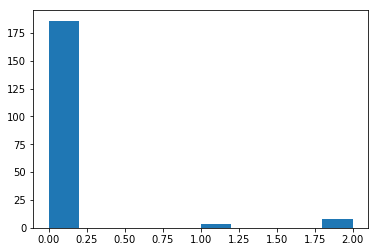

In [187]:
plt.hist(test_label)

(array([ 1873.,     0.,     0.,     0.,     0.,    27.,     0.,     0.,
            0.,    48.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

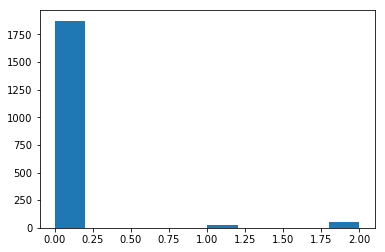

In [188]:
plt.hist(train_label)